In [265]:
import os
import json
from datetime import datetime, timedelta
import pandas as pd
import csv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pandas import Series

In [266]:
#function to convert time to same standard across dataframes
def convert_time(row):
    d = datetime.strptime(row, '%d/%m/%Y %H:%M').date()
    d.strftime('%Y-%m-%d')
    return(d)

In [306]:
#NDX = Nasdaq100 5min intervall intraday data, add avg between open and close
NDX          = pd.read_csv('NDX Index.csv', sep=',')
                       
NDX['avg']   =NDX[['Open','Close']].mean(axis=1)
NDX['log_r'] =np.log(NDX['avg']).diff() * np.log(NDX['avg']).diff()
NDX['Date'] = NDX.Dates.apply(convert_time)
NDX = NDX.fillna(NDX.mean())

#add column date without time stamp
Date = NDX['Date']
NDX.drop(labels=['Date'], axis=1,inplace = True)
NDX.insert(0, 'Date', Date) 

In [307]:
#NDX = Nasdaq100 5min intervall intraday data, add avg between open and close
AAPL = pd.read_csv('AAPL US Equity.csv', sep=',')
AAPL['avg']=AAPL[['Open','Close']].mean(axis=1)
AAPL['log_r'] =np.log(AAPL['avg']).diff() * np.log(AAPL['avg']).diff()
AAPL['Date'] = AAPL.Dates.apply(convert_time)
AAPL = AAPL.fillna(AAPL.mean())

#add column date without time stamp
Date = AAPL['Date']
AAPL.drop(labels=['Date'], axis=1,inplace = True)
AAPL.insert(0, 'Date', Date)

In [308]:
#create new data frame with unique dates, sum up intraday squared returns per day
NDX_agg = pd.DataFrame(NDX.Date.unique())
NDX_agg.columns = ['Date']

NDX_agg = pd.concat([NDX_agg, pd.DataFrame(columns = ['IntradayRV']),pd.DataFrame(columns = ['Frequency'])])

for i in range(len(NDX_agg)):
    temp_RV=0
    temp_num=0
    for j in range(len(NDX)):
        if NDX_agg.Date[i]==NDX.Date[j]:
            temp_RV=temp_RV+NDX.log_r[j]
            temp_num=temp_num+1
    NDX_agg.IntradayRV[i]= np.sqrt(temp_RV/temp_num * 87 * 252) 
    NDX_agg.Frequency[i]=temp_num  

/Users/althof/anaconda3/envs/txt/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [309]:
#create new data frame with unique dates, sum up intraday squared returns per day
AAPL_agg = pd.DataFrame(NDX.Date.unique())
AAPL_agg.columns = ['Date']

AAPL_agg = pd.concat([NDX_agg, pd.DataFrame(columns = ['IntradayRV']),pd.DataFrame(columns = ['Frequency'])])

for i in range(len(AAPL_agg)):
    temp_RV=0
    temp_num=0
    for j in range(len(AAPL)):
        if AAPL_agg.Date[i]==AAPL.Date[j]:
            temp_RV=temp_RV+AAPL.log_r[j]
            temp_num=temp_num+1
    AAPL_agg.IntradayRV[i]= np.sqrt(temp_RV/temp_num * 87 * 252) 
    AAPL_agg.Frequency[i]=temp_num  

/Users/althof/anaconda3/envs/txt/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


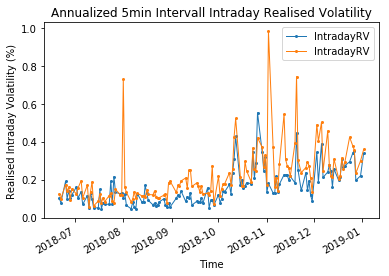

In [310]:
plt.plot(NDX_agg.Date,NDX_agg.IntradayRV, 'o-',linewidth=1, markersize=2)
plt.plot(AAPL_agg.Date,AAPL_agg.IntradayRV, 'o-',linewidth=1, markersize=2)

plt.title('Annualized 5min Intervall Intraday Realised Volatility')
plt.xlabel('Time')
plt.ylabel('Realised Intraday Volatility (%)')
plt.gcf().autofmt_xdate()
plt.savefig('RealisedIntradayVol.png',dpi = 720,transparent=True)
plt.legend(loc='upper right', )

In [311]:
print(AAPL_agg['IntradayRV'].mean())
print(AAPL_agg['IntradayRV'].max())

print(NDX_agg['IntradayRV'].mean())
print(NDX_agg['IntradayRV'].max())


0.2186433254950639
0.9819922957865711
0.15973912775310595
0.5533717968072951


In [312]:
Comb_agg = pd.DataFrame(NDX.Date.unique())
Comb_agg.columns = ['Date']

Comb_agg = pd.concat([Comb_agg, pd.DataFrame(columns = ['IRV_ratio'])])

for i in range(len(Comb_agg)):
    Comb_agg.IRV_ratio[i] = AAPL_agg.IntradayRV[i] / NDX_agg.IntradayRV[i]
        
print(Comb_agg.IRV_ratio.mean(),Comb_agg.IRV_ratio.max())
print(Comb_agg.IRV_ratio.quantile(q=0.9))
print(Comb_agg.IRV_ratio.quantile(q=0.1))

1.4936339755966777 7.0542713015003935
2.148985578199939
0.9656950024774642


/Users/althof/anaconda3/envs/txt/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


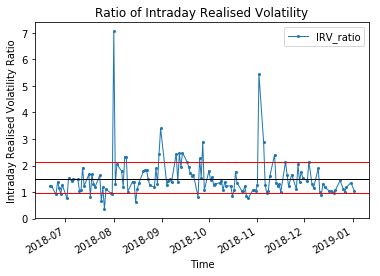

In [313]:
plt.plot(Comb_agg.Date,Comb_agg.IRV_ratio, 'o-',linewidth=1, markersize=2)

IRVratio_mean = Comb_agg.IRV_ratio.mean()
IRVratio_q10 = Comb_agg.IRV_ratio.quantile(q=0.1)
IRVratio_q90 = Comb_agg.IRV_ratio.quantile(q=0.9)

plt.axhline(y=IRVratio_mean, xmin=0, xmax=1, linewidth=1, color = 'k')
plt.axhline(y=IRVratio_q10, xmin=0, xmax=1, linewidth=1, color = 'r')
plt.axhline(y=IRVratio_q90, xmin=0, xmax=1, linewidth=1, color = 'r')

plt.title('Ratio of Intraday Realised Volatility')
plt.xlabel('Time')
plt.ylabel('Intraday Realised Volatility Ratio')
plt.gcf().autofmt_xdate()
plt.savefig('RVRatio.png',dpi = 720,transparent=True)
plt.legend(loc='upper right', )